In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io
%matplotlib inline

### 1. Training the entire data-set

In [2]:
# loading data
mat = scipy.io.loadmat('ex4data1.mat')
X = mat['X']
Y = mat['y']

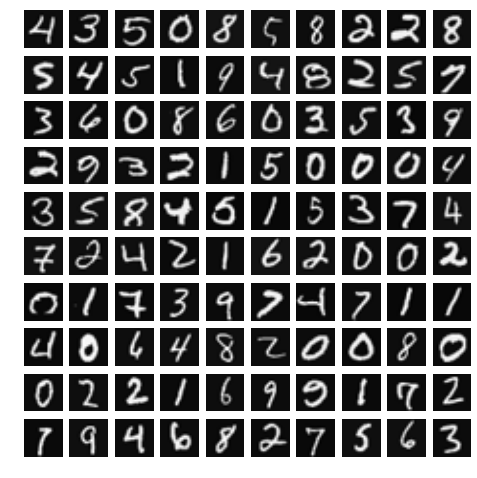

In [3]:
#visualize the data, randomly select 100 samples
samples = np.random.randint(0, X.shape[0], 100)
fig = plt.figure(figsize = (8, 8))

for i in range(len(samples)):
    data = X[samples[i], :].reshape([20, 20]).T
    data = data/data.max()
    ax = fig.add_subplot(10, 10, i+1)
    ax.imshow(data, 'gray')
    ax.axis('off')

### Use a 3-layer neural network to train dataset

<img src="Neural_Network_schematic.png" />

In [4]:
# 3-layer neural network
theta = scipy.io.loadmat('ex4weights.mat')
theta1 = theta['Theta1']
theta2 = theta['Theta2']

#set up parameters
input_layer = 400
hidden_layer = 25
num_labels = 10
nn_params = np.concatenate((theta1.flatten(), theta2.flatten()) , axis=0)
lam = 1.0

In [5]:
def sigmoid(X):
    return 1.0/(1 + np.exp(-X))

def nnCostFunc(nn_params, input_layer=input_layer, hidden_layer=hidden_layer, 
               num_labels=num_labels, X=X, Y=Y, lam=1.0):
    theta1 = nn_params[0:(input_layer+1)*hidden_layer].reshape([hidden_layer, input_layer+1])
    theta2 = nn_params[(input_layer+1)*hidden_layer:].reshape([num_labels, hidden_layer+1])
    
    m = X.shape[0]
    
    J = 0 # cost function
    theta1_grad = np.zeros(theta1.shape) # first layer gradient
    theta2_grad = np.zeros(theta2.shape) # second layer gradient

    # adding bias feature to X
    X = np.hstack((np.ones([m, 1]), X))
    
    #forward propagation
    h2 = sigmoid(theta1.dot(X.T))
    h2 = np.vstack((np.ones([1, m]), h2))
    h3 = sigmoid(theta2.dot(h2)) # 10x5000 matrix
    
    #reshape Y data
    Y_2 = np.zeros(h3.shape)
    for col in range(Y.shape[0]):
        Y_2[Y[col, 0] - 1, col] = 1

    J = 1.0/m*np.sum(-Y_2*np.log(h3) - (1 - Y_2)*np.log(1-h3))
    # regularized cost func
    J = J + lam/(2*m)*(np.sum(theta1[:, 1:]**2) + np.sum(theta2[:, 1:]**2))
    
    return J

def calc_gradient(nn_params, input_layer=input_layer, hidden_layer=hidden_layer, 
               num_labels=num_labels, X=X, Y=Y, lam=1.0):

    theta1 = nn_params[0:(input_layer+1)*hidden_layer].reshape([hidden_layer, input_layer+1])
    theta2 = nn_params[(input_layer+1)*hidden_layer:].reshape([num_labels, hidden_layer+1])
    m = X.shape[0]
    
    theta1_grad = np.zeros(theta1.shape) # first layer gradient
    theta2_grad = np.zeros(theta2.shape) # second layer gradient
 
    X = np.hstack((np.ones([m, 1]), X))
    h2 = sigmoid(theta1.dot(X.T))
    h2 = np.vstack((np.ones([1, m]), h2))
    h3 = sigmoid(theta2.dot(h2)) # 10x5000 matrix
    
    Y_2 = np.zeros(h3.shape)
    for col in range(Y.shape[0]):
        Y_2[Y[col, 0] - 1, col] = 1
        
    # Back-propagation
    for i in range(m):
        e_3 = (h3[:, i, None] - Y_2[:, i, None])
        e_2 = theta2.T.dot(e_3)*(h2[:, i, None]*(1 - h2[:, i, None]))
        theta2_grad = theta2_grad + e_3.dot((h2[:, i, None]).T)
        theta1_grad = theta1_grad + e_2[1:].dot(X[i,None, :])
        
    theta2_grad = theta2_grad/m
    theta1_grad = theta1_grad/m
    
    # regularization
    theta2[:, 0] = 0
    theta1[:, 0] = 0
    
    theta2_grad = theta2_grad + (lam/m)*theta2
    theta1_grad = theta1_grad + (lam/m)*theta1

    return np.concatenate((theta1_grad.flatten(), theta2_grad.flatten()) , axis=0)
    
def ran_init_w(L_in, L_out):
    W = np.zeros([L_out, 1+L_in])
    epsilon = 0.12 # kind of a random choice
    W = np.random.rand(L_out, L_in+1)*2*epsilon - epsilon
    return W

In [6]:
#initialize theta values
i_theta1 = ran_init_w(input_layer, hidden_layer)
i_theta2 = ran_init_w(hidden_layer, num_labels)
initial_nn_params = np.concatenate((i_theta1.flatten(), i_theta2.flatten()) , axis=0)

In [7]:
# training dataset, max 50 iterations
from scipy.optimize import fmin_cg
theta = fmin_cg(f=nnCostFunc, x0=initial_nn_params, fprime=calc_gradient, maxiter=50)

         Current function value: 0.489185
         Iterations: 50
         Function evaluations: 106
         Gradient evaluations: 106


In [11]:
# predict dataset based on training result
def predict(f_theta, X=X, input_layer=input_layer, hidden_layer=hidden_layer, 
               num_labels=num_labels):
    theta1 = f_theta[0:(input_layer+1)*hidden_layer].reshape([hidden_layer, input_layer+1]).copy()
    theta2 = f_theta[(input_layer+1)*hidden_layer:].reshape([num_labels, hidden_layer+1]).copy()
    m = X.shape[0]
    
    X = np.hstack((np.ones([m, 1]), X))
    h2 = sigmoid(theta1.dot(X.T))
    h2 = np.vstack((np.ones([1, m]), h2))
    h3 = sigmoid(theta2.dot(h2))
    
    predict = (h3.argmax(axis=0) + 1).reshape([X.shape[0], 1])
    return predict
  

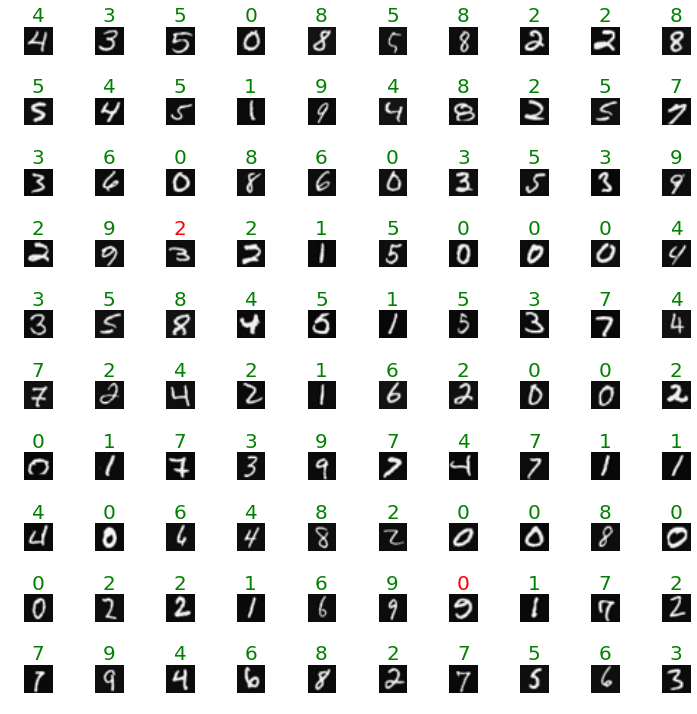

In [13]:
predict_result = predict(theta)

fig = plt.figure(figsize = (10, 10))
for i in range(len(samples)):
    
    data = X[samples[i], :].reshape([20, 20]).T
    data = data/data.max()
    
    ax = fig.add_subplot(10, 10, i+1)
    label = predict_result[samples[i], 0]

    if label == Y[samples[i], 0]:
        color = 'g' # correct prediction
    else:
        color = 'r'# incorrect prediction
    
    if label==10:
        label=0
        
    ax.imshow(data, 'gray')
    ax.axis('off')
    ax.set_title(str(label), color=color, fontsize=20)
fig.tight_layout()

### 2. Training/Testing set

- Randomly select 80% of the data as training set and test on the other 20%